# А/Б тестирование новой системы рекомендаций товара

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import pingouin as pg

Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

In [ ]:
products = pd.read_csv('ab_products.csv')
products.head(3)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4


In [ ]:
prod_id     = products.product_id.to_list()
prod_prices = products.price.to_list()
prices_dict = dict(zip(prod_id, prod_prices))

In [ ]:
prices_dict = {1: 150.0, 2: 50.0, 3: 80.4, 4: 45.5, 5: 15.0, 6: 25.0, 7: 350.8, 8: 30.4, 9: 83.5, 10: 12.0, 11: 200.0, 12: 278.3, 13: 800.0, 14: 60.0, 15: 450.0, 16: 120.0, 17: 190.0, 18: 58.0, 19: 180.0, 20: 50.0, 21: 282.5, 22: 120.0, 23: 45.3,  24: 120.4, 25: 150.0, 26: 70.0, 27: 120.6, 28: 75.3, 29: 170.0, 30: 140.0, 31: 67.4, 32: 55.0, 33: 60.0, 34: 98.0, 35: 90.4, 36: 250.8, 37: 559.3, 38: 76.3, 39: 45.0, 40: 40.0, 41: 80.4, 42: 66.0, 43: 400.0, 44: 60.0, 45: 78.0,  46: 45.5, 47: 50.0, 48: 50.5, 49: 55.0, 50: 35.0, 51: 194.5, 52: 76.3, 53: 78.3, 54: 1.0, 55: 150.0, 56: 150.0, 57: 450.3, 58: 70.0, 59: 250.0, 60: 60.0, 61: 380.0, 62: 120.0, 63: 38.8, 64: 200.0, 65: 100.0, 66: 370.4, 67: 30.0, 68: 115.5, 69: 175.3, 70: 75.0, 71: 75.4, 72: 66.3, 73: 15.4, 74: 60.0,75: 120.0, 76: 55.5, 77: 298.4, 78: 70.0, 79: 64.9, 80: 50.0, 81: 30.0, 82: 30.4, 83: 55.0, 84: 90.4, 85: 200.3, 86: 70.3, 87: 398.3}

In [ ]:
orders = pd.read_csv('ab_orders.csv')
orders.head(3)

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"


In [ ]:
# Посмотрим количество заказов
orders.shape[0]

4123

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [ ]:
# Объединяю таблицы для последующей работы
# users_data.merge(orders, on = ['order_id', 'creation_time'])

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [ ]:
users_data = pd.read_csv('ab_users_data.csv')
users_data.head(3)

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0


In [ ]:
# Посмотрим, какие бывают действия
users_data.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

In [ ]:
users_data.shape[0]

4337

In [ ]:
# Количество созданных заказов совпадает с размерам таблицы orders
users_data.query('action == "create_order"').shape[0]

4123

In [ ]:
# Переводим дату в правильный формат
users_data.time = users_data.time.apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
users_data.time = users_data.time.dt.time
users_data.date = users_data.date.apply(pd.to_datetime, format='%Y-%m-%d', errors='coerce')

In [ ]:
cancel_orders = users_data.query('action == "cancel_order"').order_id.to_list()

In [ ]:
# Оставим только те заказы, которые не были отмены
approved_users_data =  users_data.query('order_id not in @cancel_orders')

In [ ]:
# Посмотрим, сколько заказов были отменены
users_data.query('action == "cancel_order"').shape[0]

214

In [ ]:
# Сколько осталось
users_data.query('order_id not in @cancel_orders').shape[0]

3909

In [ ]:
# Проверяем, что осталось нужное количество
4337-2*214 == 3909

True

### Оценим различие суммы чека внутри групп

In [ ]:
user_orders = approved_users_data.merge(orders, on=['order_id']).drop(columns='creation_time')
user_orders.head(3)

,user_id,order_id,action,time,date,group,product_ids
0,964,1255,create_order,00:00:19,2022-08-26,0,"{75, 22, 53, 84}"
1,965,1256,create_order,00:02:21,2022-08-26,1,"{56, 76, 39}"
2,964,1257,create_order,00:02:27,2022-08-26,0,"{76, 34, 41, 38}"


In [ ]:
# Избавимся от скобок
user_orders.product_ids = user_orders.product_ids.str.strip("{}")
ids = user_orders.product_ids.str.split(', ', expand=True)
user_orders = pd.concat([user_orders, ids], axis=1)

In [ ]:
user_orders = user_orders.rename(columns={0: 'c0', 1: 'c1', 2: 'c2', 3: 'c3', 4: 'c4', 5: 'c5', 6: 'c6', 7: 'c7'})

In [ ]:
# чтобы поменять тип колонок, избавимя от пропусков
user_orders = user_orders.fillna(0)

In [ ]:
user_orders = user_orders.astype({'c0': 'int64', 'c1': 'int64', 'c2': 'int64', 'c3': 'int64', 'c4': 'int64', 'c5': 'int64', 'c6': 'int64', 'c7': 'int64'})

In [ ]:
user_orders.dtypes

user_id                 int64
order_id                int64
action                 object
time                   object
date           datetime64[ns]
group                   int64
product_ids            object
c0                      int64
c1                      int64
c2                      int64
c3                      int64
c4                      int64
c5                      int64
c6                      int64
c7                      int64
dtype: object

In [ ]:
# Меняем значения на цены из словаря с ценами
user_orders['c0'] = user_orders['c0'].map(prices_dict)
user_orders['c1'] = user_orders['c1'].map(prices_dict)
user_orders['c2'] = user_orders['c2'].map(prices_dict)
user_orders['c3'] = user_orders['c3'].map(prices_dict)
user_orders['c4'] = user_orders['c4'].map(prices_dict)
user_orders['c5'] = user_orders['c5'].map(prices_dict)
user_orders['c6'] = user_orders['c6'].map(prices_dict)
user_orders['c7'] = user_orders['c7'].map(prices_dict)

In [ ]:
user_orders = user_orders.fillna(0)
user_orders['orded_price'] = user_orders['c0'] + user_orders['c1'] + user_orders['c2'] + user_orders['c3'] + user_orders['c4'] + user_orders['c5'] + user_orders['c6'] + user_orders['c7']

In [ ]:
user_orders

,user_id,order_id,action,time,date,group,product_ids,c0,c1,c2,c3,c4,c5,c6,c7,orded_price
0,964,1255,create_order,00:00:19,2022-08-26,0,"75, 22, 53, 84",120.0,120.0,78.3,90.4,0.0,0.0,0.0,0.0,408.7
1,965,1256,create_order,00:02:21,2022-08-26,1,"56, 76, 39",150.0,55.5,45.0,0.0,0.0,0.0,0.0,0.0,250.5
2,964,1257,create_order,00:02:27,2022-08-26,0,"76, 34, 41, 38",55.5,98.0,80.4,76.3,0.0,0.0,0.0,0.0,310.2
3,967,1259,create_order,00:03:37,2022-08-26,1,"20, 45, 67, 26",50.0,78.0,30.0,70.0,0.0,0.0,0.0,0.0,228.0
4,968,1261,create_order,00:05:35,2022-08-26,0,"30, 35, 69, 6",140.0,90.4,175.3,25.0,0.0,0.0,0.0,0.0,430.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3904,990,59422,create_order,23:13:03,2022-09-08,1,"84, 8, 24",90.4,30.4,120.4,0.0,0.0,0.0,0.0,0.0,241.2
3905,1418,59439,create_order,23:18:05,2022-09-08,1,"9, 25, 75, 30, 6",83.5,150.0,120.0,140.0,25.0,0.0,0.0,0.0,518.5
3906,1605,59464,create_order,23:22:27,2022-09-08,0,"60, 41, 46",60.0,80.4,45.5,0.0,0.0,0.0,0.0,0.0,185.9
3907,1461,59487,create_order,23:29:06,2022-09-08,0,"9, 62, 77",83.5,120.0,298.4,0.0,0.0,0.0,0.0,0.0,501.9


In [ ]:
control_orders = user_orders.query('group==0')
user_orders.query('group==0').shape[0]

1527

In [ ]:
test_orders = user_orders.query('group==1')
user_orders.query('group==1').shape[0]

2382

In [ ]:
pg.normality(control_orders['orded_price'])

,W,pval,normal
orded_price,0.917026,3.811184e-28,False


In [ ]:
pg.normality(test_orders['orded_price'])

,W,pval,normal
orded_price,0.900532,8.388620e-37,False


Значение p-уровня значимости настолько низкие, что смысла проверять выборку на нормальность другими методами не вижу. T-тест можно провести и в случае ненормального распределения при достаточно большой выборке, но сначала посмотрим на характер распределения и наличие выбросов.

Text(0.5, 1.0, 'Распределение суммы чека внутри групп')

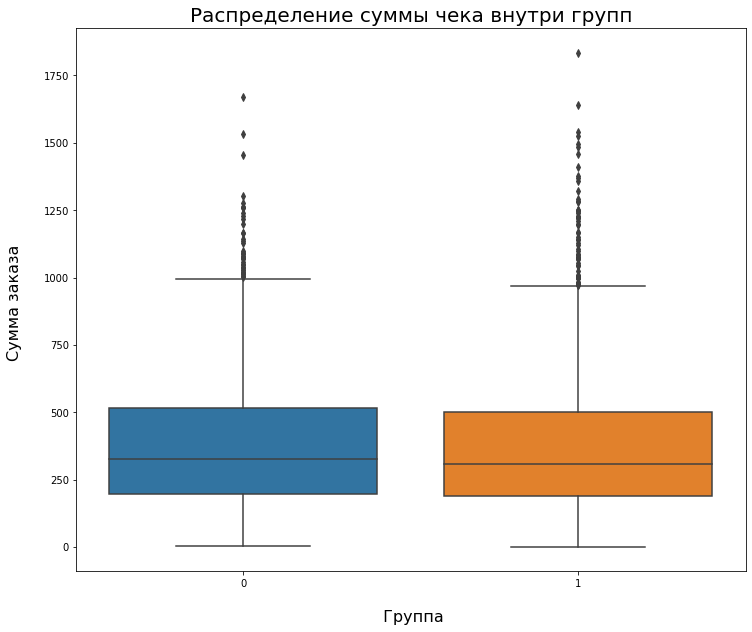

In [ ]:
# Визуализируем разброс суммы заказов
plt.rcParams['figure.figsize'] = [12, 10]
sns.boxplot(data = user_orders, x='group', y='orded_price')
plt.ylabel('Сумма заказа \n', size=16)
plt.xlabel('\n Группа',       size=16)
plt.title('Распределение суммы чека внутри групп',  size=20)

Распределение сумм заказов ненормальное, имеет большое количество выбросов. На графике видим, что квартили распределений значительно пересекаются. Будем использовать метод бутстрап.

In [ ]:
Nboot = 10000
x_p = user_orders.query('group==0')['orded_price'].to_numpy()
y_p = user_orders.query('group==1')['orded_price'].to_numpy()
ci, dist = pg.compute_bootci(
    x_p,
    y_p,
    func=lambda x, y: np.mean(x) - np.mean(y),
    confidence=0.95,
    n_boot=Nboot,
    return_dist=True
)
print(ci)

[-5.71 29.96]


#### Даже с помощью метода бутстрап не удалось получить статистически значимые различия между средними двух групп. Раздность средних проходит через 0.

##  Оценим различия средней выручки на пользователя

In [ ]:
rev_per_user = user_orders.groupby(['group', 'user_id'], as_index=False)\
                           .agg({'orded_price':'sum'})\
                           .rename(columns={'orded_price': 'user_rev'})

rev_per_user['user_rev'] = rev_per_user.user_rev.round(2)
rev_per_user.head()

,group,user_id,user_rev
0,0,964,718.9
1,0,968,1590.7
2,0,969,681.9
3,0,972,546.4
4,0,975,1432.9


In [ ]:
pg.normality(rev_per_user.query('group==0')['user_rev'])

,W,pval,normal
user_rev,0.888535,8.713837e-19,False


Text(0.5, 1.0, 'Распределение выручки с пользователя внутри групп')

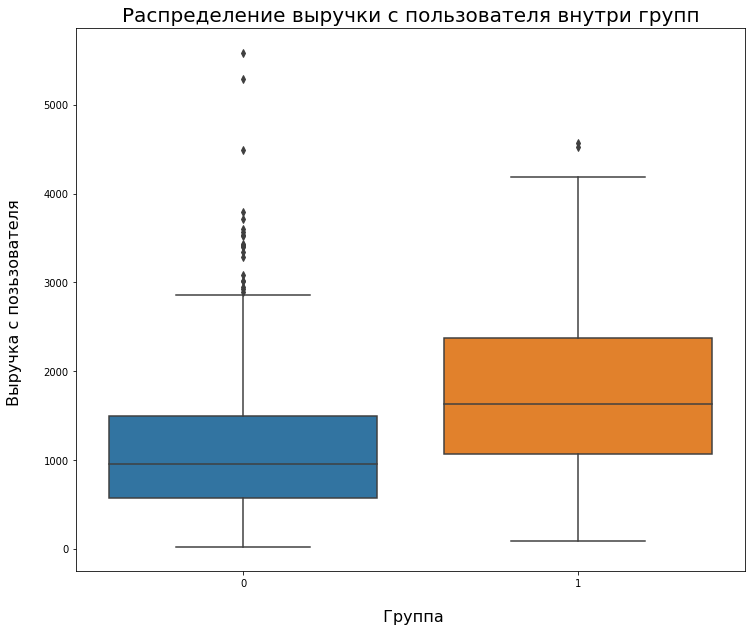

In [ ]:
# Визуализируем разброс суммы заказов
plt.rcParams['figure.figsize'] = [12, 10]
sns.boxplot(data = rev_per_user, x='group', y='user_rev')
plt.ylabel('Выручка с позьзователя \n', size=16)
plt.xlabel('\n Группа',                 size=16)
plt.title('Распределение выручки с пользователя внутри групп',  size=20)

In [ ]:
Nboot = 10000
x = rev_per_user.query('group==0')['user_rev'].to_numpy()
y = rev_per_user.query('group==1')['user_rev'].to_numpy()

In [ ]:
ci, dist = pg.compute_bootci(
    x,
    func='mean',
    confidence=0.95,
    n_boot=Nboot,
    paired=False,
    return_dist=True
)
print(ci)

[1071.73 1211.16]


In [ ]:
ci, dist = pg.compute_bootci(
    y,
    func='mean',
    confidence=0.95,
    n_boot=Nboot,
    paired=False,
    return_dist=True
)
print(ci)

[1672.59 1835.93]


In [ ]:
ci, dist = pg.compute_bootci(
    x,
    y,
    func=lambda x, y: np.mean(x) - np.mean(y),
    confidence=0.95,
    n_boot=Nboot,
    return_dist=True
)
print(ci)

[-721.04 -512.22]


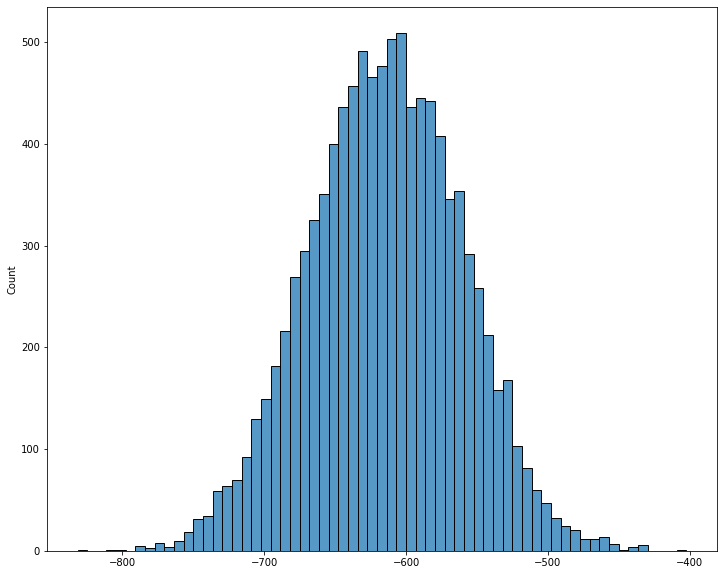

In [ ]:
sns.histplot(dist)

#### Можем заключить, что средняя выручка на одного пользователя статистически значимо отличается в тестовой и контрольной группах, доверительные интервалы не пересекаются. В тестовой группе в среднем выручка на пользователя больше. При том, что мы не увидели значительных различий между суммами чеков в группах, похоже, что пользователи в тестовой группе делают заказы чаще.

##  Оценим среднее количество заказов пользователей

In [ ]:
orders_num = user_orders.groupby(['group', 'user_id'], as_index=False)\
                         .agg({'orded_price':'count'})\
                         .rename(columns={'orded_price': 'orders_num'})

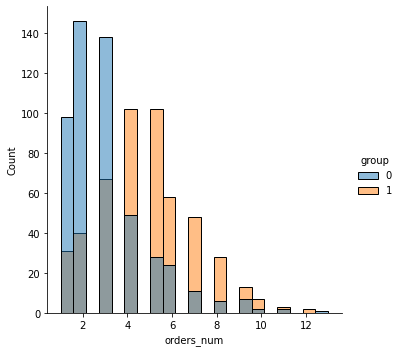

In [ ]:
sns.displot(data=orders_num, x='orders_num', hue='group')

In [ ]:
Nboot = 10000
x2 = orders_num.query('group==0')['orders_num'].to_numpy()
y2 = orders_num.query('group==1')['orders_num'].to_numpy()

In [ ]:
ci, dist = pg.compute_bootci(
    x2,
    func='mean',
    confidence=0.95,
    n_boot=Nboot,
    paired=False,
    return_dist=True
)
print(ci)

[2.82 3.15]


In [ ]:
ci, dist = pg.compute_bootci(
    y2,
    func='mean',
    confidence=0.95,
    n_boot=Nboot,
    paired=False,
    return_dist=True
)
print(ci)

[4.57 4.94]


In [ ]:
ci, dist = pg.compute_bootci(
    x2,
    y2,
    func=lambda x, y: np.mean(y) - np.mean(x),
    confidence=0.95,
    n_boot=Nboot,
    return_dist=True
)
print(ci)

[1.53 2.01]


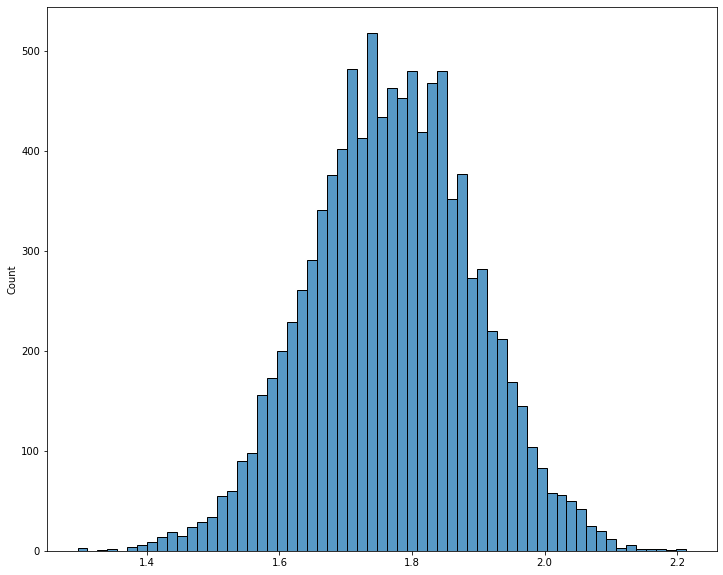

In [ ]:
sns.histplot(dist)

#### Видим статистически значимое различие средних значений числа покупок. Доверительные интервалы не пересекаются. Можем сделать вывод, что в условиях тестовой группы пользователи будут делать покупки чаще.

## Узнаем, различается ли количество отменённых заказов

In [ ]:
user_orders.groupby(['group'], as_index=False)\
                                             .agg({'action':'count'})\
                                             .rename(columns={'action': 'order_num'})

,group,order_num
0,0,1527
1,1,2382


In [ ]:
users_data.query('action == "cancel_order"').groupby(['group'], as_index=False)\
                                             .agg({'action':'count'})\
                                             .rename(columns={'action': 'cansel_num'})

,group,cansel_num
0,0,82
1,1,132


Посколько переменные категориальные (заказ был отменён/заказ не был отменён) будем использовать тест хи-квадрат

Нулевая гипотиза: количество отменённых заказов в тестовой и контрольной группах не различаются
Альтернативная:   количество отменённых заказов в тестовой и контрольной группах различаются

In [ ]:
from scipy.stats import chi2_contingency
obs = np.array([[1527, 82], [2382, 132]])

chi2_contingency(obs)

(0.021274207290295187,
 0.8840344321879333,
 1,
 array([[1525.48653893,   83.51346107],
        [2383.51346107,  130.48653893]]))

#### p-уровень значимости > 0.05,  поэтому у нас недостаточно оснований отклонить нулевую гипотезу. Т.е. Мы не можем сказать, что есть различие в количестве отмен в тестовой и контрольных группах.

# Вывод:

##  Анализ результатов тестирования новой системы рекомендации товаров показал, что в тестовой группе пользователи стали чаще делать заказы, средняя выручка на пользователя, таким образом увеличилась. Новая система рекомендаций не повлияла на средний чек и количество отменённых заказов.

# Рекумендую ввести новую систему рекомендаций.